In [1]:
import os
import h5py
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import iglob
from keras.models import Model
import matplotlib.pyplot as plt
from keras.preprocessing import image   
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

random.seed(9527)

Using TensorFlow backend.


1、加载测试集数据

In [2]:
test_image = iglob('./all/test/*')
test_files = np.array(list(test_image))
test_files[:5]

array(['./all/test\\1.jpg', './all/test\\10.jpg', './all/test\\100.jpg',
       './all/test\\1000.jpg', './all/test\\10000.jpg'], dtype='<U20')

2、数据预处理

In [3]:
def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(299, 299))
    # 将PIL.Image.Image类型转化为格式为(299, 299, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 299, 299, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
from PIL import ImageFile
from keras.applications.xception import Xception, preprocess_input
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# 实现了归一化处理。
test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:32<00:00, 340.02it/s]


In [5]:
# 创建预训练模型
base_model = Xception(weights='imagenet', include_top=False)

# 添加一个全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 提取特征的模型
model = Model(inputs=base_model.input, outputs=x)

In [6]:
test = model.predict(test_tensors)

In [7]:
X_test = np.array(test)

3、加载特征向量

In [8]:
with h5py.File("features_Xception.h5", 'r') as h:
    X_train = np.array(h['train'])
    Y_train = np.array(h['label'])

4、构建模型

In [9]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

5、训练模型

In [10]:
result = model.fit(X_train, Y_train, batch_size=128, epochs=8, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - ETA: 2:00 - loss: 0.7146 - acc: 0.539 - ETA: 6s - loss: 0.4557 - acc: 0.8741  - ETA: 3s - loss: 0.3412 - acc: 0.929 - ETA: 1s - loss: 0.2757 - acc: 0.950 - ETA: 1s - loss: 0.2338 - acc: 0.960 - ETA: 0s - loss: 0.2051 - acc: 0.966 - ETA: 0s - loss: 0.1844 - acc: 0.970 - ETA: 0s - loss: 0.1683 - acc: 0.973 - ETA: 0s - loss: 0.1537 - acc: 0.975 - 1s 67us/step - loss: 0.1457 - acc: 0.9769 - val_loss: 0.0441 - val_acc: 0.9918
Epoch 2/8
20000/20000 [==============================] - ETA: 0s - loss: 0.0646 - acc: 0.992 - ETA: 0s - loss: 0.0544 - acc: 0.990 - ETA: 0s - loss: 0.0515 - acc: 0.990 - ETA: 0s - loss: 0.0484 - acc: 0.991 - ETA: 0s - loss: 0.0471 - acc: 0.990 - ETA: 0s - loss: 0.0445 - acc: 0.991 - ETA: 0s - loss: 0.0427 - acc: 0.991 - ETA: 0s - loss: 0.0403 - acc: 0.991 - ETA: 0s - loss: 0.0402 - acc: 0.991 - 0s 25us/step - loss: 0.0395 - acc: 0.9915 - val_loss: 0.0241 - val_acc

In [11]:
result.history

{'val_loss': [0.044144301825761796,
  0.024078390261530875,
  0.019330625288188456,
  0.01750801012068987,
  0.01646828453242779,
  0.01584575206451118,
  0.015467300565168261,
  0.015224326853081584],
 'val_acc': [0.9918, 0.9946, 0.9942, 0.9944, 0.9942, 0.9944, 0.9946, 0.9942],
 'loss': [0.14572744399011134,
  0.03946091593503952,
  0.027986999097466467,
  0.025154550391435625,
  0.02421317187845707,
  0.021612837810069323,
  0.021536763644218446,
  0.020659119087085127],
 'acc': [0.9769, 0.99155, 0.99305, 0.99325, 0.99285, 0.99365, 0.994, 0.99385]}

In [12]:
np.array(result.history.get("val_acc")).mean()

0.99405

In [13]:
val_acc = np.array(result.history.get("val_acc"))
acc = np.array(result.history.get("acc"))

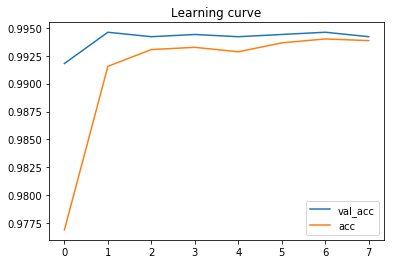

In [14]:
plt.plot(val_acc, label='val_acc')
plt.plot(acc, label='acc')

plt.title('Learning curve')
plt.legend()
plt.show()

6、预测测试集

In [15]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)


df = pd.read_csv("all/sample_submission.csv")
for i, fname in enumerate(test_files):
    index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('predictions.csv', index=False)
df.head(10)

12500/12500 [==============================] - ETA: 45 - ETA: 0 - ETA:  - ETA:  - ETA:  - 0s 28us/step


c:\python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [16]:
end_logloss= 0.04107

In [18]:
clip_logloss = 0.04947